Try to use all the triggers

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle
from array import array
from scipy.interpolate import interp1d
from multiprocessing import Pool
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise

In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
import operator
ops = {'>': operator.gt, '<': operator.lt, '=': operator.eq, '==': operator.eq}

In [5]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Cuts declaration

In [8]:
min_trgMu_pt = 8.1
str_min_trgMu_pt = '8'

In [9]:
# Needed to prevent different mixture in trigger path (in MC all of BPH are always ON but not in data)
trigger_cuts = [
 'trgMu_HLT_Mu12_IP6 == 0',
 'trgMu_HLT_Mu9_IP6 == 0',
 'trgMu_HLT_Mu8_IP6 == 1',
 'trgMu_pt > ' + str(min_trgMu_pt),
 'trgMu_pt < 8.9',
 'trgMu_sigdxy > 7'
]

offline_cuts = [
 'mass_mumu < 3.174',
 'mass_mumu > 3.013',
 'mass_piK > 0.82',
 'mass_piK < 0.96',
 'mum_pt > 3.5',
 'mup_pt > 3.5',
 'Jpsi_pt > 7',
 'pval_mumu > 0.1',
 'mum_eta > -2.2',
 'mup_eta > -2.2',
 'mum_eta < 2.2',
 'mup_eta < 2.2',
 'cosT_Jpsi_PV > 0.95',
 'mum_dxy < 3',
 'mup_dxy < 3',
 'pval_piK > 0.1',
 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)',
 'mass_KK > 1.035',
 'K_sigdxy_PV > 2',
 'pi_sigdxy_PV > 2',
 'sigdxy_vtxKst_PV > 5',
 'K_pt > 0.8',
 'pval_mumupiK > 0.1',
 'pi_pt > 0.8',
 'mass_mumupiK > 5.01',
 'mass_mumupiK < 5.56'
]

analysis_cuts = trigger_cuts + offline_cuts
analysis_cuts_str = ' && '.join(analysis_cuts)

In [10]:
def event_trg_selection(ev):
    for c_str in trigger_cuts:
        aux = c_str.split(' ')
        if len(aux) != 3: 
            print aux
            raise
        x = getattr(ev, aux[0])
        if not ops[aux[1]](x, float(aux[2])):
            return False
    return True

In [11]:
def candidate_selection(j, ev):
    accept = abs(ev.mass_piK[j] - 0.892) < abs(ev.mass_piK_CPconj[j] - 0.892)
    for c_str in offline_cuts:
        if c_str == 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)': 
            continue
        if not accept:
            break
        aux = c_str.split(' ')
        if len(aux) != 3:
            print aux
            raise
        x = getattr(ev, aux[0])[j]
        accept = ops[aux[1]](x, float(aux[2]))
    return accept

# Load data

In [12]:
dataDir = '../data/cmsRD'
datasets_loc = []
datasets_loc += glob(dataDir + '/ParkingBPH*/*2018*B2JpsiKst_191128*')

for d in datasets_loc: print d

../data/cmsRD/ParkingBPH3/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH3/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH2/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH2/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH5/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH5/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH4/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH4/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH1/Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_191128_CAND.root


In [13]:
lumi_tot, lumi_dic = getLumiReport(datasets_loc)
CMS_lumi.integrated_lumi = lumi_tot

Lumi tot: 31.9 fb^-1
Lumi analyzed: 78.3%


### Create a skimmed tree

In [14]:
def skim_dset(dset_loc):
    output = []
    N_accepted_cand = []
    nMax = 1e11
    idx = dset_loc.find('BPH')
    part = dset_loc[idx+3]
    idx = dset_loc.find('Run2018')
    era = dset_loc[idx+7]
    f = rt.TFile(dset_loc, 'READ')
    aux_tree = f.Get('outA/Tevts')
    maxEntry=float(min(nMax, aux_tree.GetEntries()))
    for i_ev, ev in enumerate(aux_tree): 
        if i_ev >= nMax:
            break
        if i_ev % 200000 == 0:
            print era+part, ': {:.0f} %'.format(100*i_ev/maxEntry)
        N_acc = 0

        if not event_trg_selection(ev):
            continue

        for j in range(ev.pval_mumupiK.size()):
            if not candidate_selection(j, ev):
                continue
            
            N_acc += 1
            output.append((ev.mass_mumupiK[j], 
                           ev.B_mumupiK_pt[j], 
                           ev.B_mumupiK_eta[j],
                           ev.Jpsi_pt[j],
                           ev.trgMu_pt,
                           ev.trgMu_sigdxy,
                           ev.mum_pt[j],
                           ev.mum_eta[j],
                           ev.mum_isTrg[j],
                           ev.mup_eta[j],
                           ev.mup_pt[j],
                           ev.mup_isTrg[j],
                           ev.Kst_pt[j],
                           ev.Kst_eta[j],
                          ))
        if N_acc > 0:
            N_accepted_cand.append(N_acc)
    print era+part, 'done'
    return [output, N_accepted_cand]

In [15]:
recreate = False
fname = '../data/cmsRD/skimmed/B2JpsiKst_Mu{}.root'.format(str_min_trgMu_pt)
if recreate or not os.path.isfile(fname):
    p = Pool(len(datasets_loc))
    out = p.map(skim_dset, datasets_loc) 
    output = []
    N_accepted_cand = []
    for o, n in out:
        output += o
        N_accepted_cand += n
    
    print len(output)
    dic = {i:N_accepted_cand.count(i) for i in range(1, np.max(N_accepted_cand)+1)}
    print dic

    import root_numpy as rtnp
    leafs_names = ['mass_mumupiK', 'B_pt', 'B_eta', 
                   'Jpsi_pt', 
                   'trgMu_pt', 'trgMu_sigdxy', 
                   'mum_pt', 'mum_eta', 'mum_isTrg', 
                   'mup_eta', 'mup_pt', 'mup_isTrg', 
                   'Kst_pt', 'Kst_eta'
                  ]

    dtypes = []
    for n in leafs_names:
        dtypes.append((n, np.float32))

    a = np.array(output, dtype=dtypes)
    rtnp.array2root(a, fname, treename='Tevts', mode='RECREATE')

In [16]:
skimmed_file = rt.TFile(fname, 'READ')

In [17]:
skimmed_tree = skimmed_file.Get('Tevts')
skimmed_tree.Print()

******************************************************************************
*Tree    :Tevts     : Tevts                                                  *
*Entries :     3799 : Total =          221137 bytes  File  Size =     164381 *
*        :          : Tree compression factor =   1.31                       *
******************************************************************************
*Br    0 :mass_mumupiK : mass_mumupiK/F                                      *
*Entries :     3799 : Total  Size=      15789 bytes  File Size  =      11861 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.29     *
*............................................................................*
*Br    1 :B_pt      : B_pt/F                                                 *
*Entries :     3799 : Total  Size=      15749 bytes  File Size  =      13149 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.16     *
*...................................................

In [18]:
N_exp_per_fb = skimmed_tree.GetEntries()/lumi_tot
print 'Measured events per fb: {:.0f}'.format(N_exp_per_fb)

Measured events per fb: 119


# Load MC

In [19]:
mcDir = '../data/cmsMC_private'

In [20]:
mcsets_loc = glob(mcDir + '/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3/jobs_B2JpsiKst/out_CAND*.root')
treeMC = rt.TChain('outA/Tevts')
for floc in mcsets_loc:
    treeMC.Add(floc)
    
N_cand = treeMC.GetEntries()
N_sel = treeMC.GetEntries(analysis_cuts_str)
print 'N files: {:.0f}'.format(len(mcsets_loc))
print 'N evts candidate: {:.0f}'.format(N_cand)
print 'N evts selected: {:.0f}'.format(N_sel)
analysisSelEff = N_sel/float(N_cand)

N files: 163
N evts candidate: 186113
N evts selected: 4285


In [21]:
dic_MCeff = pickle.load(open('../data/SidePTMC_efficiencies.pickle', 'rb'))
dic_decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

In [22]:
n = 'JPsiKst'
xsec_eff = dic_MCeff[n]['xsec']
print 'Pythia xsec: {:1.2e} pb'.format(xsec_eff)
xsec_eff *= dic_decayBR[n]
print 'Forced decays BR: {:1.2e}'.format(dic_decayBR[n])
xsec_eff *= dic_MCeff[n]['CMSSWFilterEff']
print'Eff CMSSW filter: {:1.2e}'.format(dic_MCeff[n]['CMSSWFilterEff'])
xsec_eff *= dic_MCeff[n]['ntupplizerEff']
print'Eff ntuplizer: {:1.2e}'.format(dic_MCeff[n]['ntupplizerEff'])
xsec_eff *= analysisSelEff
print'Eff selection: {:1.2e}'.format(analysisSelEff)
xsec_eff *= 1e3 # pb -> fb
print '\nExpected evts/fb: {:.0f}'.format(xsec_eff)
print '\n'
xsec_eff *= 1.65/5.27
print 'Ratio with observed: {:.0f}/{:.0f} = {:.2f}'.format(xsec_eff, N_exp_per_fb, xsec_eff/N_exp_per_fb)

Pythia xsec: 1.49e+08 pb
Forced decays BR: 7.57e-05
Eff CMSSW filter: 9.99e-03
Eff ntuplizer: 5.90e-02
Eff selection: 2.30e-02

Expected evts/fb: 153


Ratio with observed: 48/119 = 0.40


# Analyze data

### Fit the whole dataset

In [23]:
width = 0.005 #GeV
N = 95
m_min = 5.03
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=np.arange(start=5.03, stop=5.5, step=0.005)
               )
skimmed_tree.Project('h', 'mass_mumupiK')
h.Sumw2()

In [24]:
m_min = h.GetBinCenter(1) -  0.5*h.GetBinWidth(1)
N = h.GetNbinsX()
m_max = h.GetBinCenter(N) +  0.5*h.GetBinWidth(N)
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', m_min, m_max, 'GeV')

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.02, 0.00005, 0.1, 'GeV') 
# pdf_sig = rt.RooGaussian('gaus','sig pdf', mass, mean, sigma)

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# alpha = rt.RooRealVar('alpha', '#alpha', 2, -5, 5, 'GeV')
# nCB = rt.RooRealVar('nCB', 'n_{CB}', 2, -10, 10, 'GeV')
# pdf_sig = rt.RooCBShape('gaus','sig pdf', mass, mean, sigma, alpha, nCB)

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
# pAsym.setConstant(rt.kTRUE)
rho1 = rt.RooRealVar('rho1', '#rho_{1}', -0.5, -10, 0)
# rho1.setConstant(rt.kTRUE)
rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)

N_tot = h.Integral(1, h.GetNbinsX())
nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [25]:
lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)

# a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
# a1 = rt.RooRealVar('a1', 'a1', -0.1, -10, 100)
# a2 = rt.RooRealVar('a2', 'a2', 0.1, -100, 100)
# pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(a1, a2), 1)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 100*N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

In [26]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())

chi2: 103.0/85 0.089
Total: Nsig = 2861, Nbkg = 796


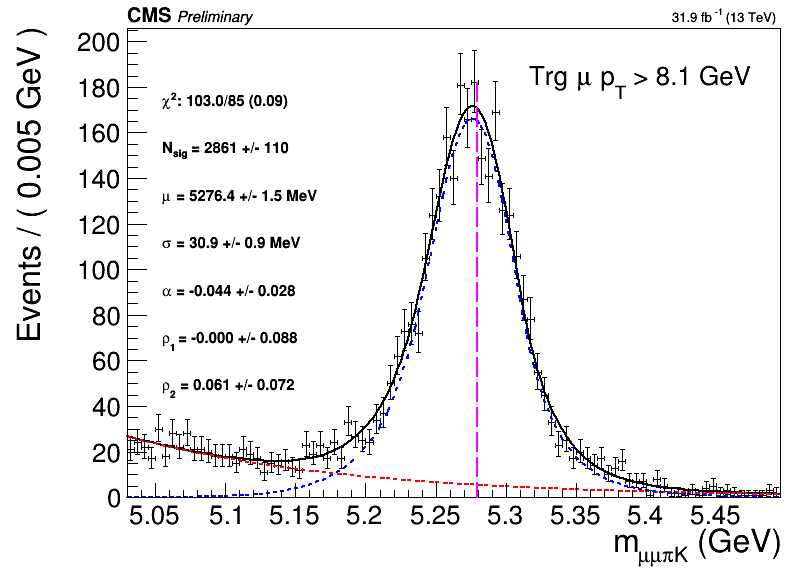

In [27]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()), rf.MarkerStyle(15))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(2))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

x_min = h.binning[1] + (h.binning[-1]-h.binning[1])*0.03
x_max = h.binning[1] + (h.binning[-1]-h.binning[1])*0.3
pTxt = rt.TPaveText(x_min, 0.2*h.GetMaximum(), x_max, h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))
pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

text = rt.TLatex()
text.SetTextAlign(31)
text.SetTextSize(0.06)
text.SetTextFont(42)
text.SetTextSize(0.05)

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()
text.DrawLatexNDC(0.95, 0.85, 'Trg #mu p_{{T}} > {:.1f} GeV'.format(min_trgMu_pt));

### Make sDataset

In [28]:
v_B_pt = rt.RooRealVar('B_pt', 'p_{T}^{(B)}', 0, 500, 'GeV')
v_B_eta = rt.RooRealVar('B_eta', '#eta^{(B)}', -3, 3, 'GeV')
v_trgMu_pt = rt.RooRealVar('trgMu_pt', '#mu_{trg} p_{T}', 0, 1000, 'GeV')

rt.RooAbsData.setDefaultStorageType(rt.RooAbsData.Tree)
ds = rt.RooDataSet('ds', 'ds', skimmed_tree, rt.RooArgSet(mass, v_B_eta, v_B_pt, v_trgMu_pt))
ds.convertToTreeStore()

In [29]:
sData = rt.RooStats.SPlot('sData', 'sData', ds, pdf_tot, rt.RooArgList(nsig, nbkg))
sData.GetYieldFromSWeight('nsig_sw')

2861.799056080104

In [30]:
f_sw = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst_Mu{}_sw.root'.format(str_min_trgMu_pt), 'RECREATE')
ds.convertToTreeStore()
treeRD_skimmed = ds.tree()
treeRD_skimmed.Write()
f_sw.Close()

In [31]:
f_sw = rt.TFile('../data/cmsRD/skimmed/B2JpsiKst_Mu{}_sw.root'.format(str_min_trgMu_pt), 'READ')
treeRD_skimmed = f_sw.Get('merged')
treeRD_skimmed.Print()

******************************************************************************
*Tree    :merged    : merged                                                 *
*Entries :     3657 : Total =          248664 bytes  File  Size =     174691 *
*        :          : Tree compression factor =   1.00                       *
******************************************************************************
*Br    0 :mass_mumupiK : mass_mumupiK/D                                      *
*Entries :     3657 : Total  Size=      31145 bytes  All baskets in memory   *
*Baskets :        7 : Basket Size=       4096 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :B_eta     : B_eta/D                                                *
*Entries :     3657 : Total  Size=      31005 bytes  All baskets in memory   *
*Baskets :        7 : Basket Size=       4096 bytes  Compression=   1.00     *
*...................................................

# Analyze MC

In [32]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=array('d', list(np.arange(start=5.15, stop=5.37, step=0.005)) + [5.38, 5.4])
               )
treeMC.Project('h', 'mass_mumupiK', analysis_cuts_str)
h.Sumw2()

In [33]:
N_tot = h.Integral(1, h.GetNbinsX())
print N_tot
print h.Integral()

4280.0
4280.0


In [34]:
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', h.binning[0], h.binning[-1], 'GeV')

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.02, 0.00005, 0.1, 'GeV') 
# pdf_sig = rt.RooGaussian('gaus','sig pdf', mass, mean, sigma)

# mean = rt.RooRealVar('mean', 'm_{B}', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# alpha = rt.RooRealVar('alpha', '#alpha', 2, -5, 5, 'GeV')
# nCB = rt.RooRealVar('nCB', 'n_{CB}', 2, -10, 10, 'GeV')
# pdf_sig = rt.RooCBShape('gaus','sig pdf', mass, mean, sigma, alpha, nCB)

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
rho1 = rt.RooRealVar('rho1', '#rho_{1}', -0.5, -10, 0)
rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)


nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [35]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = pdf_sig_ext
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX() - fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

chi2: 36.3/39 0.593


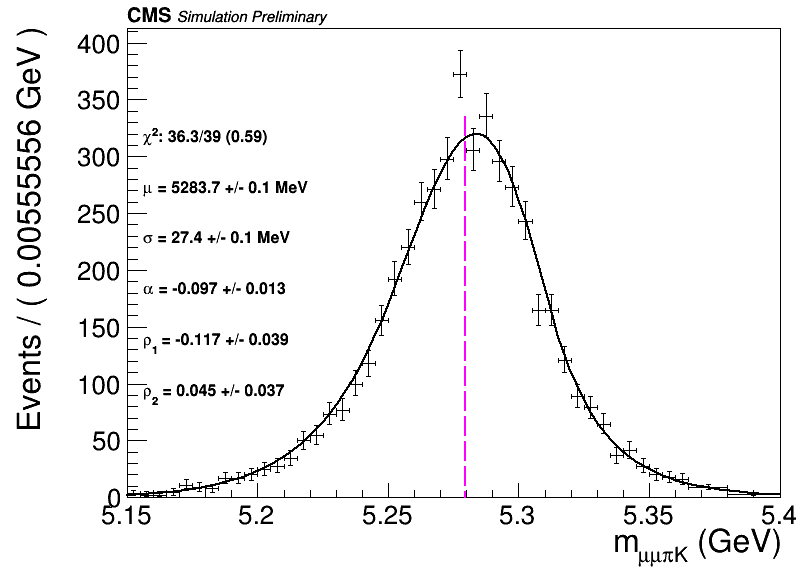

In [36]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(2))

pTxt = rt.TPaveText(h.GetBinCenter(1), 0.2*h.GetMaximum(), h.GetBinCenter(int(0.35*h.GetNbinsX())), h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

CMS_lumi.extraText = '     Simulation Preliminary'
CMS_lumi.integrated_lumi = ''
c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()

# Compare

### Closure variables

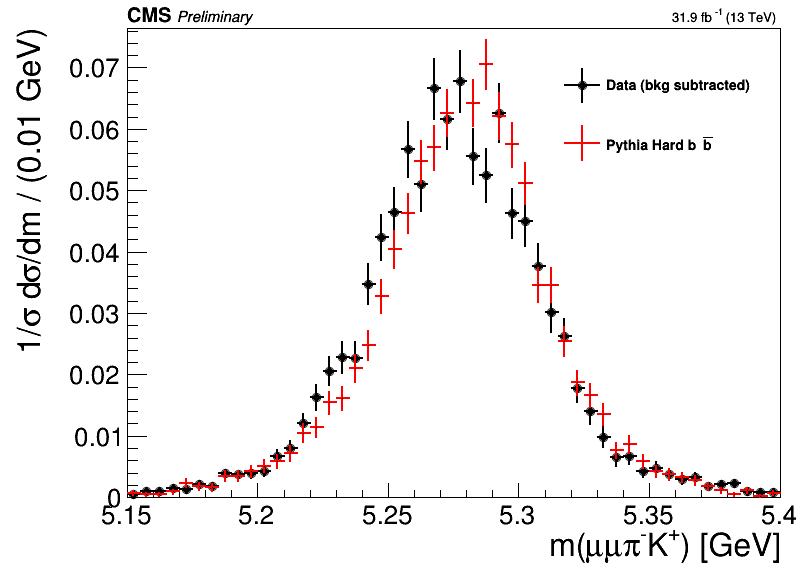

In [37]:
b=[50, 5.15, 5.4]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', '1/#sigma d#sigma/dm / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                binning=b
               )
treeRD_skimmed.Project('hRD', 'mass_mumupiK', 'L_nsig/(L_nsig+L_nbkg)')
# treeRD_skimmed.Project('hRD', 'mass_mumupiK', '')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

hMC = create_TH1D(np.zeros(0), name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning, opt='overflow+underflow')
treeMC.Project('hMC', 'mass_mumupiK', analysis_cuts_str)
hMC.Sumw2()
hMC.Scale(1./hMC.Integral())
hMC.SetLineColor(rt.kRed)
    
leg = rt.TLegend(0.7, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMC, 'Pythia Hard b#bar{b}', 'le')

CMS_lumi.extraText = '     Preliminary'
CMS_lumi.integrated_lumi = lumi_tot
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC], 'same')
leg.Draw()

### The true B spectrum

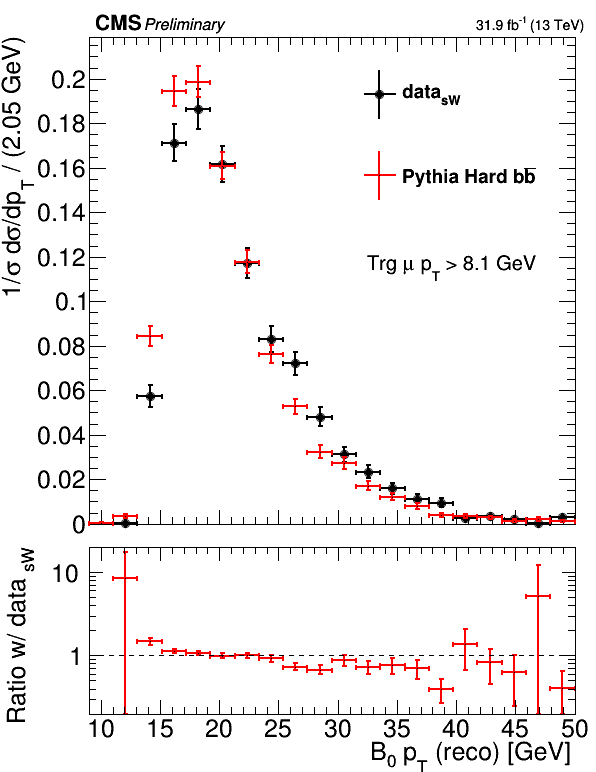

In [40]:
b = [20, 9, 50.]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='data_{sW}',
                axis_title=['B_{0} p_{T} (reco) [GeV]', 
                            '1/#sigma d#sigma/dp_{T} / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                binning=b,
                opt='overflow+underflow'
               )
treeRD_skimmed.Project('hRD', 'B_pt', 'nsig_sw')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

hMC = create_TH1D(np.zeros(0), name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning, opt='overflow+underflow')
treeMC.Project('hMC', 'B_mumupiK_pt', analysis_cuts_str)
hMC.Sumw2()
hMC.Scale(1./hMC.Integral())
hMC.SetLineColor(rt.kRed)

CMS_lumi.extraText = '      Preliminary'
c = make_ratio_plot([hRD, hMC], ratio_bounds=[0.2, 20], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

c.pad2.cd()
ln = rt.TLine()
ln.SetLineStyle(7)
ln.SetLineColor(1)
ln.DrawLine(hRD.binning[1], 1, hRD.binning[2], 1)

c.pad1.cd()
text.SetTextSize(0.04)
text.DrawLatexNDC(0.9, 0.5, 'Trg #mu p_{{T}} > {:.1f} GeV'.format(min_trgMu_pt));

In [41]:
dic = {'pt':[], 'w':[], 'w_err':[], 'wUp':[], 'wDown':[]}

def f_arb(x, value_at_beg):
    center = 0.5*(hRD.binning[2] + hRD.binning[1])
    k = (value_at_beg-1)/(hRD.binning[1] -  center)
    return k*(x - center)+1

fout = open('../data/calibration/B02JPsiKst_Mu{}_pt.txt'.format(str_min_trgMu_pt), 'w')
fout.write('#'+'\t'.join(['pt','w', 'w_err', 'wUp', 'wDown'])+'\n')
for ib in range(1, hRD.GetNbinsX()+1):
    n = max(0, hRD.GetBinContent(ib))
    d = hMC.GetBinContent(ib)
    en = 0.
    ed = 0.
    if n > 0: en = hRD.GetBinError(ib)/n
    if d > 0: ed = hMC.GetBinError(ib)/d
    r = n/d
    dic['w'].append(r)
    if en != 0 and ed != 0:
        dr = r*np.hypot(en, ed)
    elif en == 0:
        dr = 0.5
    dic['w_err'].append(dr)
    pt = hRD.GetBinCenter(ib)
    dic['pt'].append(pt)
    
    dic['wUp'].append(r * f_arb(pt, 0.5))
    dic['wDown'].append(r * f_arb(pt, 1.5))
    
    fout.write('\t'.join(map(lambda x: '{:.3f}'.format(x), [pt, r, dr, r * f_arb(pt, 0.), r * f_arb(pt, 2.)]))+'\n')
fout.close()

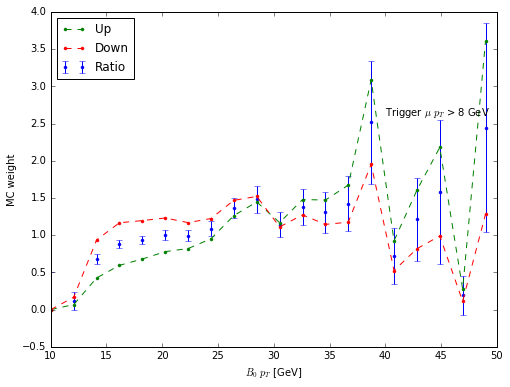

In [42]:
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.', label='Ratio')
plt.plot(dic['pt'], dic['wUp'], '.--', label='Up')
plt.plot(dic['pt'], dic['wDown'], '.--', label='Down')
plt.legend(loc='best')
plt.xlabel('$B_0\ p_T$ [GeV]')
plt.ylabel('MC weight')
plt.text(40,2.6, 'Trigger $\mu \  p_T$ > '+str_min_trgMu_pt + ' GeV')

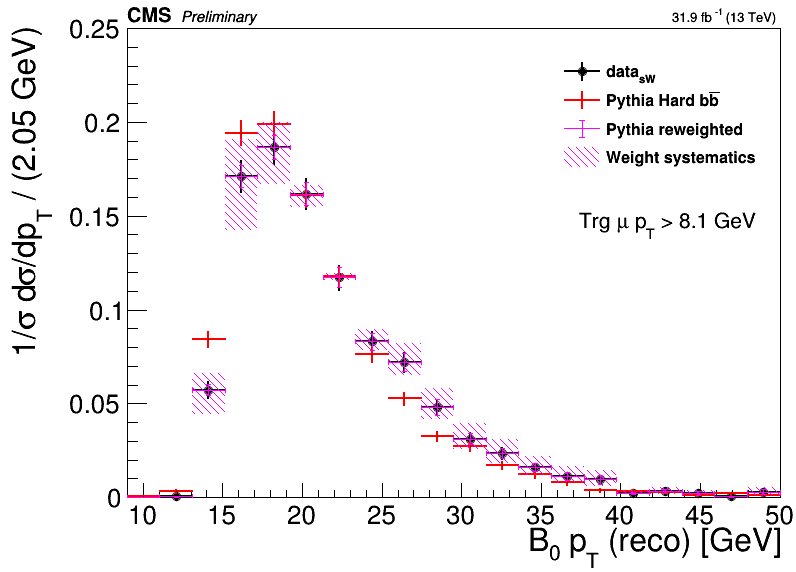

In [45]:
h_var = {}
colors = [5,6,8]
for k in ['central', 'up', 'down']:
    h_var[k] = hMC.Clone('hMC_'+k)
    h_var[k].SetTitle(k)
    h_var[k].SetLineColor(colors[0])
    h_var[k].SetMarkerColor(colors[0])
    h_var[k].SetMarkerStyle(rt.kCircle)
    colors.pop(0)
    
for ib in range(1, hRD.binning[0]+1):
    x = hRD.GetBinCenter(ib)
    y = hMC.GetBinContent(ib)
    y_err = hMC.GetBinError(ib)
    h_var['central'].SetBinContent(ib, y*dic['w'][ib-1])
    h_var['central'].SetBinError(ib, y_err*dic['w'][ib-1])
    h_var['up'].SetBinContent(ib, y*dic['wUp'][ib-1])
    h_var['up'].SetBinError(ib, y_err*dic['wUp'][ib-1])
    h_var['down'].SetBinContent(ib, y*dic['wDown'][ib-1])    
    h_var['down'].SetBinError(ib, y_err*dic['wDown'][ib-1])
for h in h_var.values():
    h.Scale(1./h.Integral())
    
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
for ib in range(1, hRD.binning[0]+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['central'].GetBinContent(ib)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['central'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['up'].GetBinContent(ib), y-h_var['down'].GetBinContent(ib))
    dy_up = max(h_var['up'].GetBinContent(ib)-y, h_var['down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
gr_stat.SetLineColor(6)
gr_stat.SetMarkerColor(6)
gr_sys.SetFillColor(6)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.7, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, hMC.GetTitle(), 'le')
leg.AddEntry(gr_stat, 'Pythia reweighted', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

hRD.GetYaxis().SetRangeUser(0, .25)
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC, gr_stat, gr_sys], ['', 'same', 'p', '2'])
leg.Draw()
text.DrawLatexNDC(0.95, 0.6, 'Trg #mu p_{{T}} > {:.1f} GeV'.format(min_trgMu_pt));

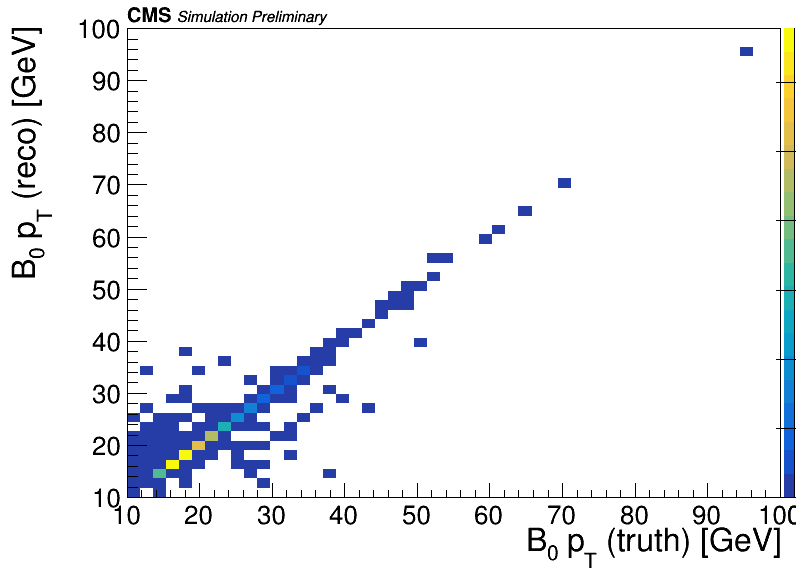

In [46]:
b=[50, 10, 100, 50, 10, 100]
hMC2D = create_TH2D(np.zeros((2,2)), name='hMC',
                title='',
                axis_title=['B_{0} p_{T} (truth) [GeV]', 'B_{0} p_{T} (reco) [GeV]', ''],
                binning=b
               )
treeMC.Project('hMC', 'B_mumupiK_pt:MC_B_pt', analysis_cuts_str)

CMS_lumi.extraText = '     Simulation Preliminary'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'])

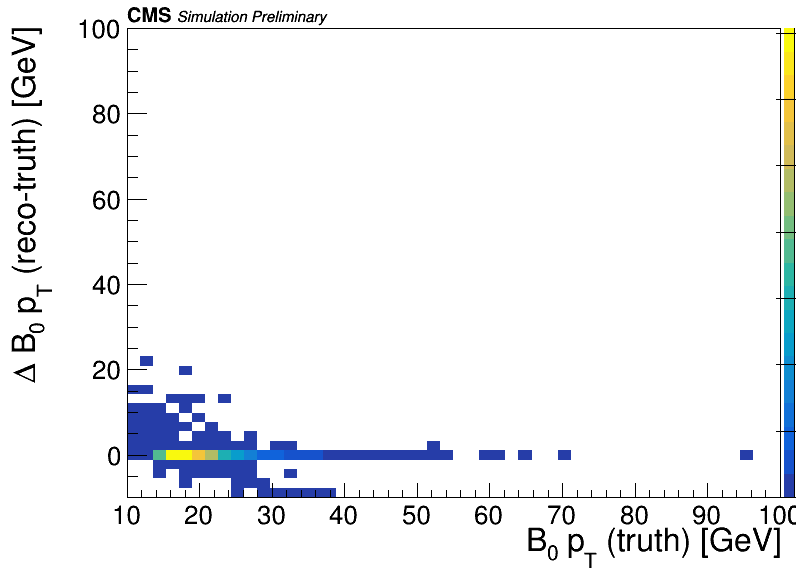

In [47]:
b=[50, 10, 100, 50, -10, 100]
hMC2D = create_TH2D(np.zeros((2,2)), name='hMC',
                title='',
                axis_title=['B_{0} p_{T} (truth) [GeV]', '#Delta B_{0} p_{T} (reco-truth) [GeV]', ''],
                binning=b
               )
treeMC.Project('hMC', 'B_mumupiK_pt - MC_B_pt:MC_B_pt', analysis_cuts_str)

CMS_lumi.extraText = '     Simulation Preliminary'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'])

In [48]:
treeMC.GetEntries(analysis_cuts_str + ' && abs(B_mumupiK_pt - MC_B_pt) < 10')/float(treeMC.GetEntries(analysis_cuts_str))

0.9813302217036173

In [49]:
class PTCalibration:
    def __init__(self, calibration_dic=None, calibration_file=None):
        if not calibration_dic is None:
            self.calibration_dic = calibration_dic
            d = calibration_dic
        elif not calibration_file is None:
            d = {}
            lines = open(calibration_file, 'r').readlines()
            keys = lines[0][1:-1].split('\t')
            for k in keys: d[k] = []
            
            for l in lines[1:]:
                l = l[:-1]
                v = l.split('\t')
                for i in range(len(v)):
                    d[keys[i]].append(float(v[i]))
            
            self.calibration_dic = d
        else:
            raise
        
        self.f = {}
        self.f['C'] = interp1d(d['pt'], d['w'], 
                               fill_value=(d['w'][0], d['w'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Up'] = interp1d(d['pt'], d['wUp'], 
                               fill_value=(d['wUp'][0], d['wUp'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Down'] = interp1d(d['pt'], d['wDown'], 
                               fill_value=(d['wDown'][0], d['wDown'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
cal_pT = PTCalibration(calibration_file='../data/calibration/B02JPsiKst_Mu{}_pt.txt'.format(str_min_trgMu_pt))

In [50]:
output = []
N_accepted_cand = []

nMax = 1e11
aux_tree = treeMC
maxEntry=float(min(nMax, aux_tree.GetEntries()))
pb = ProgressBar(maxEntry=maxEntry)
for i_ev, ev in enumerate(aux_tree): 
    pb.show(i_ev)
    if i_ev >= nMax:
        break
        
    N_acc = 0

    if not event_trg_selection(ev):
        continue

    for j in range(ev.pval_mumupiK.size()):
        if not candidate_selection(j, ev):
            continue

        N_acc += 1
        output.append((ev.B_mumupiK_pt[j],
                       ev.MC_B_pt,
                      ))
        for k in ['C', 'Up', 'Down']:
            w = cal_pT.f[k](ev.MC_B_pt)
            output[-1] += (w,)
    if N_acc > 0:
        N_accepted_cand.append(N_acc)

dic = {i:N_accepted_cand.count(i) for i in range(1, np.max(N_accepted_cand)+1)}
print dic
leafs_names = ['B_pt', 'MC_B_pt'] + ['wC', 'wUp', 'wDown']

dtypes = []
for n in leafs_names:
    dtypes.append((n, np.float32))

dSet_MC = np.array(output, dtype=dtypes)

[####################]  100% - Tot. time: 28.5 s
{1: 4270, 2: 15}


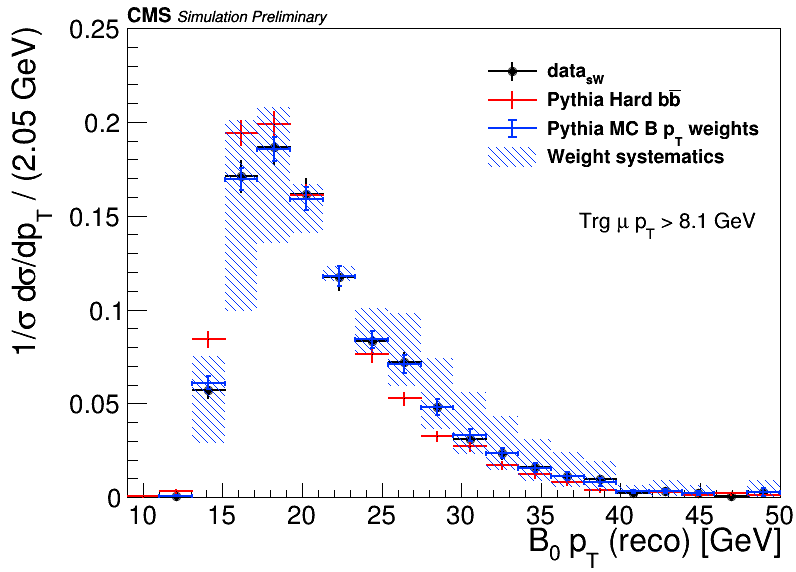

In [52]:
h_var = {}
colors = [5,6,8]
for k in ['C', 'Up', 'Down']:                    
    h = create_TH1D(dSet_MC['B_pt'], name='h_var'+k, 
                    binning=hRD.binning, 
                    opt='underflow',
                    weights=dSet_MC['w'+k],
                   )
    h.Scale(1./h.Integral())
    h_var[k] = h
    
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
for ib in range(1, hRD.binning[0]+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['C'].GetBinContent(ib)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['C'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['Up'].GetBinContent(ib), y-h_var['Down'].GetBinContent(ib))
    dy_up = max(h_var['Up'].GetBinContent(ib)-y, h_var['Down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
gr_stat.SetLineColor(rt.kAzure)
gr_stat.SetLineWidth(2)
gr_stat.SetMarkerColor(rt.kAzure)
gr_sys.SetFillColor(rt.kAzure)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.6, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, hMC.GetTitle(), 'le')
leg.AddEntry(gr_stat, 'Pythia MC B p_{T} weights', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

hRD.GetYaxis().SetRangeUser(0, .25)
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC, gr_stat, gr_sys], ['', 'same', 'p', '2'])
leg.Draw()
text.DrawLatexNDC(0.95, 0.6, 'Trg #mu p_{{T}} > {:.1f} GeV'.format(min_trgMu_pt));

In [ ]:
# sel = dSet_MC['B_pt'] > 96.95
# print np.sum(sel)
# print np.sum(dSet_MC['wC'][sel])/np.sum(dSet_MC['wC'])
# print np.sum(dSet_MC['wC'][sel])
# dSet_MC['wC'][sel]

In [ ]:
# h_var['C'].GetBinCenter(h_var['C'].GetNbinsX()) - 0.5*h_var['C'].GetBinWidth(h_var['C'].GetNbinsX())

In [ ]:
# rtnp.array2root(dSet_MC, '/storage/user/ocerri/test.root',treename='t', mode='RECREATE')